<a href="https://colab.research.google.com/github/veeransr/ML-and-Deep-learning-practice-with-python/blob/master/Pyspark_PCA_very_imp_java_issue_and_findspark_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()

In [0]:
!pip install pyspark

     |████████████████████████████████| 217.8MB 56kB/s 
     |████████████████████████████████| 204kB 40.1MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=5375a3abcea2ea29a8a954e13e83316b3a29dfbc5458cf8197a9c1311eb40fce
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [0]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.util import MLUtils
import numpy as np
from pyspark.ml.feature import StandardScaler
import pyspark.sql.functions as f
import pyspark.sql.types
import pandas as pd
from pyspark.sql import Row
spark = SparkSession.builder.getOrCreate()
sc = SparkContext.getOrCreate()
from pyspark.ml.feature import VectorAssembler

In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/venky14/Machine-Learning-with-Iris-Dataset/master/Iris.csv")
df = df.drop(['Species'], axis = 1)
spark_df = spark.createDataFrame(df)

In [0]:
spark_df.show(10)

+---+-------------+------------+-------------+------------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|
+---+-------------+------------+-------------+------------+
|  1|          5.1|         3.5|          1.4|         0.2|
|  2|          4.9|         3.0|          1.4|         0.2|
|  3|          4.7|         3.2|          1.3|         0.2|
|  4|          4.6|         3.1|          1.5|         0.2|
|  5|          5.0|         3.6|          1.4|         0.2|
|  6|          5.4|         3.9|          1.7|         0.4|
|  7|          4.6|         3.4|          1.4|         0.3|
|  8|          5.0|         3.4|          1.5|         0.2|
|  9|          4.4|         2.9|          1.4|         0.2|
| 10|          4.9|         3.1|          1.5|         0.1|
+---+-------------+------------+-------------+------------+
only showing top 10 rows



Create a single vector column
We can use VectorAssembler transformer to combine a given list of columns into a single vector column.

In [0]:
cols = spark_df.drop('Id').columns
cols

['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']

In [0]:
assembler = VectorAssembler(inputCols=cols, outputCol = 'features')
output_dat = assembler.transform(spark_df).select('Id', 'features')
output_dat.show(5, truncate = False)

+---+-----------------+
|Id |features         |
+---+-----------------+
|1  |[5.1,3.5,1.4,0.2]|
|2  |[4.9,3.0,1.4,0.2]|
|3  |[4.7,3.2,1.3,0.2]|
|4  |[4.6,3.1,1.5,0.2]|
|5  |[5.0,3.6,1.4,0.2]|
+---+-----------------+
only showing top 5 rows



In Spark, unlike R and like Python, the PCA decomposition will not scale the input data automatically. There is no parameter that controls whether to center or standardize the data. We have to process our data before applying PCA. Now, let's center our data. We do not need to scale it (withStd=False).

In [0]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=False, withMean=True)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(output_dat)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(output_dat)
scaledData.select(['Id', 'scaledFeatures']).show(5, truncate = False) # sample centered data

+---+--------------------------------------------------------------------------------+
|Id |scaledFeatures                                                                  |
+---+--------------------------------------------------------------------------------+
|1  |[-0.7433333333333332,0.4460000000000006,-2.358666666666667,-0.998666666666667]  |
|2  |[-0.9433333333333325,-0.05399999999999938,-2.358666666666667,-0.998666666666667]|
|3  |[-1.1433333333333326,0.1460000000000008,-2.458666666666667,-0.998666666666667]  |
|4  |[-1.2433333333333332,0.04600000000000071,-2.258666666666667,-0.998666666666667] |
|5  |[-0.8433333333333328,0.5460000000000007,-2.358666666666667,-0.998666666666667]  |
+---+--------------------------------------------------------------------------------+
only showing top 5 rows



In [0]:
scaler.getOutputCol()

'scaledFeatures'

In [0]:
pca = PCA(k=4, inputCol = 'scaledFeatures', outputCol="pcaFeatures")

model = pca.fit(scaledData)
transformed_feature = model.transform(scaledData)

In [0]:
np.round(100.00*model.explainedVariance.toArray(),4)

array([92.4616,  5.3016,  1.7185,  0.5183])

In [0]:
pcs = np.round(model.pc.toArray(),4)
pcs

array([[-0.3616, -0.6565,  0.581 ,  0.3173],
       [ 0.0823, -0.7297, -0.5964, -0.3241],
       [-0.8566,  0.1758, -0.0725, -0.4797],
       [-0.3588,  0.0747, -0.5491,  0.7511]])

In [0]:
pcs = np.round(model.pc.toArray(),4)
df_pc = pd.DataFrame(pcs, columns = ['PC1','PC2','PC3','PC4'], index = cols)
df_pc

,PC1,PC2,PC3,PC4
SepalLengthCm,-0.3616,-0.6565,0.5810,0.3173
SepalWidthCm,0.0823,-0.7297,-0.5964,-0.3241
PetalLengthCm,-0.8566,0.1758,-0.0725,-0.4797
PetalWidthCm,-0.3588,0.0747,-0.5491,0.7511


In [0]:
df_pc['PC1']

SepalLengthCm   -0.3616
SepalWidthCm     0.0823
PetalLengthCm   -0.8566
PetalWidthCm    -0.3588
Name: PC1, dtype: float64

In [0]:
transformed_feature.select('pcaFeatures').show(10, truncate = False)

+-----------------------------------------------------------------------------------+
|pcaFeatures                                                                        |
+-----------------------------------------------------------------------------------+
|[2.6842071251039488,-0.3266073147643894,0.021511837001963352,0.0010061572415417386]|
|[2.7153906156341314,0.1695568475560246,0.2035214250054912,0.09960242401681774]     |
|[2.8898195396179167,0.1373456096050262,-0.024709240998956328,0.019304542832509375] |
|[2.7464371973087354,0.31112431575199007,-0.03767197528530031,-0.0759552741085362]  |
|[2.7285929818313153,-0.33392456356845623,-0.09622969977460838,-0.06312873271710939]|
|[2.2798973610095983,-0.7477827132251348,-0.17432561901640187,-0.027146803697900457]|
|[2.8208906821806305,0.08210451102467928,-0.26425108519069535,-0.050099625062850706]|
|[2.6264819933238193,-0.17040534896029133,0.015801510264315866,-0.0462817609665096] |
|[2.887958565335635,0.5707980263315899,-0.027335406114

We can round the PCAs above to compare the results with those from R and Python

In [0]:
transformed_feature.select('pcaFeatures').rdd.map(lambda x: Row(pcaFeatures = str([x for x in list(np.round(x[0].\
                                                    toArray(),4))]))).toDF().show(truncate = False)

+-----------------------------------+
|pcaFeatures                        |
+-----------------------------------+
|[2.6842, -0.3266, 0.0215, 0.001]   |
|[2.7154, 0.1696, 0.2035, 0.0996]   |
|[2.8898, 0.1373, -0.0247, 0.0193]  |
|[2.7464, 0.3111, -0.0377, -0.076]  |
|[2.7286, -0.3339, -0.0962, -0.0631]|
|[2.2799, -0.7478, -0.1743, -0.0271]|
|[2.8209, 0.0821, -0.2643, -0.0501] |
|[2.6265, -0.1704, 0.0158, -0.0463] |
|[2.888, 0.5708, -0.0273, -0.0266]  |
|[2.6738, 0.1067, 0.1915, -0.0559]  |
|[2.5065, -0.6519, 0.0693, -0.0166] |
|[2.6131, -0.0215, -0.1077, -0.1577]|
|[2.7874, 0.2277, 0.2003, -0.0072]  |
|[3.2252, 0.5033, -0.0684, -0.0219] |
|[2.6435, -1.1862, 0.1445, 0.157]   |
|[2.3839, -1.3448, -0.2837, 0.0019] |
|[2.6225, -0.8181, -0.1453, 0.1647] |
|[2.6483, -0.3191, -0.0334, 0.0761] |
|[2.1991, -0.8792, 0.1145, 0.0253]  |
|[2.5873, -0.5205, -0.2196, -0.0691]|
+-----------------------------------+
only showing top 20 rows



In [0]:
transformed_feature .count()

150

Cool, this works as expected. Now we obtain a sample and read each of the three columns into a python list

In [0]:
rdd = transformed_feature.rdd.sample(False,0.8)

In [0]:
x = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[0]).collect()

In [0]:
y = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[1]).collect()

In [0]:
z = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[2]).collect()

Finally we plot the three lists and name each of them as dimension 1-3 in the plot

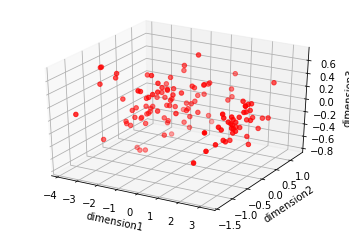

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')




ax.scatter(x,y,z, c='r', marker='o')

ax.set_xlabel('dimension1')
ax.set_ylabel('dimension2')
ax.set_zlabel('dimension3')

plt.show()

Practice second example

In [0]:
df = pd.read_csv('https://courses.edx.org/asset-v1:MITx+15.071x_2a+2T2015+type@asset+block/climate_change.csv')
spark_df = spark.createDataFrame(df)
spark_df.printSchema()

root
 |-- Year: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- MEI: double (nullable = true)
 |-- CO2: double (nullable = true)
 |-- CH4: double (nullable = true)
 |-- N2O: double (nullable = true)
 |-- CFC-11: double (nullable = true)
 |-- CFC-12: double (nullable = true)
 |-- TSI: double (nullable = true)
 |-- Aerosols: double (nullable = true)
 |-- Temp: double (nullable = true)



In [0]:
spark_df.show(5)

+----+-----+------------------+------+-------+-------+------------------+------------------+---------+--------+-------------------+
|Year|Month|               MEI|   CO2|    CH4|    N2O|            CFC-11|            CFC-12|      TSI|Aerosols|               Temp|
+----+-----+------------------+------+-------+-------+------------------+------------------+---------+--------+-------------------+
|1983|    5|             2.556|345.96|1638.59|303.677|           191.324|350.11300000000006|1366.1024|  0.0863|              0.109|
|1983|    6|             2.167|345.52|1633.71|303.746|192.05700000000002|           351.848|1366.1208|  0.0794|0.11800000000000001|
|1983|    7|1.7409999999999999|344.15|1633.22|303.795|192.81799999999998|           353.725| 1366.285|  0.0731|0.13699999999999998|
|1983|    8|              1.13|342.25|1631.35|303.839|           193.602|355.63300000000004|1366.4202|  0.0673|0.17600000000000002|
|1983|    9|             0.428|340.17| 1648.4|303.901|           194.392|   

We create a single vector column following the same steps we did in the first case above. But now we will center and standardize the data before applying PCA. We do not need to include temperature in the features vector. We want to perform PCA over the other variables.

In [0]:
cols = spark_df.drop('Temp').columns
cols

['Year',
 'Month',
 'MEI',
 'CO2',
 'CH4',
 'N2O',
 'CFC-11',
 'CFC-12',
 'TSI',
 'Aerosols']

In [0]:
assembler = VectorAssembler(inputCols=cols, outputCol = 'features')
output_dat = assembler.transform(spark_df).select('Temp', 'features')
output_dat.show(5, truncate = False)

+-------------------+-------------------------------------------------------------------------------------------------+
|Temp               |features                                                                                         |
+-------------------+-------------------------------------------------------------------------------------------------+
|0.109              |[1983.0,5.0,2.556,345.96,1638.59,303.677,191.324,350.11300000000006,1366.1024,0.0863]            |
|0.11800000000000001|[1983.0,6.0,2.167,345.52,1633.71,303.746,192.05700000000002,351.848,1366.1208,0.0794]            |
|0.13699999999999998|[1983.0,7.0,1.7409999999999999,344.15,1633.22,303.795,192.81799999999998,353.725,1366.285,0.0731]|
|0.17600000000000002|[1983.0,8.0,1.13,342.25,1631.35,303.839,193.602,355.63300000000004,1366.4202,0.0673]             |
|0.149              |[1983.0,9.0,0.428,340.17,1648.4,303.901,194.392,357.465,1366.2335,0.0619]                        |
+-------------------+-------------------

Again, since the variables have different columns, we standardize the data by passing withStd=True.

In [0]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(output_dat)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(output_dat)
scaledData.select(['Temp', 'scaledFeatures']).show(5, truncate = False)

+-------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Temp               |scaledFeatures                                                                                                                                                                                       |
+-------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0.109              |[-1.7057795516993026,-0.4502035379206729,2.4313891926587416,-1.3652710347365973,-2.415427998374155,-1.6678691628022453,-2.9977124436890437,-2.5491905227480895,0.07917956200329643,2.397379982283791]|
|0.11800000000000001|[-1.7057795516993026,-0.1601142289676031,2.0166409848574762,-1.4000615507473042,-2.521395906315118,

In [0]:
pca = PCA(k=10, inputCol = scaler.getOutputCol(), outputCol="pcaFeatures")

model = pca.fit(scaledData)
transformed_feature = model.transform(scaledData)

The variance explained are the same with R, scikit-learn and Spark

In [0]:
np.round(100.00*model.explainedVariance.toArray(),4)

array([5.19871e+01, 1.46612e+01, 1.08331e+01, 1.01167e+01, 6.23870e+00,
       5.47980e+00, 4.62300e-01, 1.48900e-01, 6.39000e-02, 8.40000e-03])

The eigenvectors are the same with R, scikit-learn and Spark

In [0]:
pcs = np.round(model.pc.toArray(),4)
pcs

array([[-4.237e-01,  1.014e-01, -1.270e-01, -2.120e-02,  2.036e-01,
         9.160e-02,  1.556e-01, -3.187e-01, -4.580e-02,  7.848e-01],
       [ 1.100e-02,  9.100e-03, -6.960e-02,  9.886e-01,  3.190e-02,
         9.060e-02,  5.400e-02,  7.000e-02, -1.810e-02,  1.800e-02],
       [ 6.970e-02, -5.125e-01, -5.834e-01, -8.220e-02, -2.100e-01,
         5.833e-01, -2.860e-02,  1.000e-03,  9.900e-03,  3.000e-04],
       [-4.128e-01,  1.341e-01, -1.264e-01, -9.710e-02,  2.475e-01,
         1.322e-01,  3.007e-01,  7.632e-01, -1.558e-01, -1.017e-01],
       [-4.262e-01, -9.200e-02, -1.070e-02,  4.920e-02, -2.820e-02,
        -8.700e-02, -8.778e-01,  1.638e-01, -7.700e-03,  3.890e-02],
       [-4.170e-01,  1.201e-01, -1.153e-01,  1.400e-02,  2.715e-01,
         1.342e-01,  7.960e-02, -3.456e-01,  6.030e-01, -4.660e-01],
       [-2.862e-01, -4.596e-01,  1.380e-01,  4.660e-02, -4.918e-01,
        -3.956e-01,  2.781e-01,  1.735e-01,  4.000e-01,  1.409e-01],
       [-4.192e-01, -1.951e-01,  9.300e-0

In [0]:
cols[:-1]

['Year', 'Month', 'MEI', 'CO2', 'CH4', 'N2O', 'CFC-11', 'CFC-12', 'TSI']

In [0]:
pcs = np.round(model.pc.toArray(),4)
df_pc = pd.DataFrame(pcs, columns = ['PC'+str(i) for i in range(1, 11)], index = cols)
df_pc

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Year,-0.4237,0.1014,-0.1270,-0.0212,0.2036,0.0916,0.1556,-0.3187,-0.0458,0.7848
Month,0.0110,0.0091,-0.0696,0.9886,0.0319,0.0906,0.0540,0.0700,-0.0181,0.0180
MEI,0.0697,-0.5125,-0.5834,-0.0822,-0.2100,0.5833,-0.0286,0.0010,0.0099,0.0003
CO2,-0.4128,0.1341,-0.1264,-0.0971,0.2475,0.1322,0.3007,0.7632,-0.1558,-0.1017
CH4,-0.4262,-0.0920,-0.0107,0.0492,-0.0282,-0.0870,-0.8778,0.1638,-0.0077,0.0389
N2O,-0.4170,0.1201,-0.1153,0.0140,0.2715,0.1342,0.0796,-0.3456,0.6030,-0.4660
CFC-11,-0.2862,-0.4596,0.1380,0.0466,-0.4918,-0.3956,0.2781,0.1735,0.4000,0.1409
CFC-12,-0.4192,-0.1951,0.0093,0.0357,-0.1428,-0.1381,0.1653,-0.3669,-0.6702,-0.3664
TSI,-0.0591,-0.3811,0.7480,0.0033,0.2102,0.4968,0.0059,0.0053,-0.0046,0.0266
Aerosols,0.1687,-0.5400,-0.1751,0.0065,0.6865,-0.4215,-0.0015,0.0063,-0.0166,0.0057


In [0]:
df_pc['PC1']

Year       -0.4237
Month       0.0110
MEI         0.0697
CO2        -0.4128
CH4        -0.4262
N2O        -0.4170
CFC-11     -0.2862
CFC-12     -0.4192
TSI        -0.0591
Aerosols    0.1687
Name: PC1, dtype: float64

In [0]:
transformed_feature.select('pcaFeatures').show(10, truncate = False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|pcaFeatures                                                                                                                                                                                                 |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[5.501970988036403,-1.033941305259777,-1.5779950804229512,-0.8329916610555118,1.9055594307863581,1.5937319453827874,-0.04031106890631596,0.08401643092961632,-0.194738126118535,0.003157775293389585]       |
|[5.464533785859555,-0.72383446996442,-1.2708952200914518,-0.5124210499419806,1.824382139670005,1.4889953863925818,0.08645636889781091,0.049477702243640356,-0.1917896329189

For comparing with the results from Python and R, I have rounded the array above.

In [0]:
transformed_feature.select('pcaFeatures').rdd.map(lambda x: Row(pcaFeatures = str([x for x in list(np.round(x[0].\
                                                    toArray(),4))]))).toDF().show(truncate = False)

+--------------------------------------------------------------------------------------+
|pcaFeatures                                                                           |
+--------------------------------------------------------------------------------------+
|[5.502, -1.0339, -1.578, -0.833, 1.9056, 1.5937, -0.0403, 0.084, -0.1947, 0.0032]     |
|[5.4645, -0.7238, -1.2709, -0.5124, 1.8244, 1.489, 0.0865, 0.0495, -0.1918, -0.0045]  |
|[5.3962, -0.5639, -0.6626, -0.1754, 1.8194, 1.5144, 0.1112, -0.0229, -0.1839, 0.01]   |
|[5.3511, -0.2881, 0.0094, 0.1805, 1.842, 1.3778, 0.1551, -0.1323, -0.1717, 0.026]     |
|[5.1791, 0.2977, 0.1301, 0.5633, 1.711, 0.7416, -0.1678, -0.1902, -0.1549, 0.0371]    |
|[4.9719, 0.7414, 0.0775, 0.9033, 1.5791, 0.3131, -0.4151, -0.1199, -0.1604, 0.03]     |
|[4.9128, 0.8821, 0.2785, 1.1926, 1.5558, 0.3606, -0.2421, -0.0533, -0.1761, 0.0126]   |
|[4.8628, 1.0046, 0.1835, 1.4647, 1.4657, 0.3921, -0.1013, 0.0381, -0.194, -0.0103]    |
|[4.736, 1.7327, -0.6

In [0]:
transformed_feature .count()

308

In [0]:
rdd = transformed_feature.rdd.sample(1,0.9)
#rdd.show()

By selecting with replacement number, it is possible to make the graph
as in sample(self, withReplacement, fraction, seed=None):

param withReplacement: can elements be sampled multiple times (replaced when sampled out)

In [0]:
#x1 = transformed_feature.map(lambda a : a.pcaFeatures).map(lambda a : a[0]).collect()

In [0]:
x = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[0]).collect()

In [0]:
#y1 = transformed_feature.map(lambda a : a.pcaFeatures).map(lambda a : a[1]).collect()

In [0]:
y = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[1]).collect()

In [0]:
#z1 = transformed_feature.map(lambda a : a.pcaFeatures).map(lambda a : a[2]).collect()

In [0]:
z = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[2]).collect()

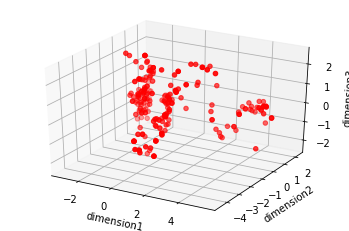

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')




ax.scatter(x,y,z, c='r', marker='o')

ax.set_xlabel('dimension1')
ax.set_ylabel('dimension2')
ax.set_zlabel('dimension3')

plt.show()